## Minimal Code to Evaluate A Neural Compression Model on SDO Image Data

#### 1. Importing required modules

In [9]:
import math

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

from tiny_compressai.models import NASACompressor

#### 2. Define saved checkpoint path/image path to be compressed, and the preferred device to use

In [10]:
checkpoint_path = './ckpt/sample_ckpt.ckpt'
image_path = './downloads/AIA20150104_0124_0094.png'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### 3. Load model with pretrained weights

In [11]:
state_dict = torch.load(checkpoint_path)['state_dict']
net = NASACompressor.from_state_dict(state_dict).eval().to(device)

#### 4. Read the candidate image and plot it for visualization

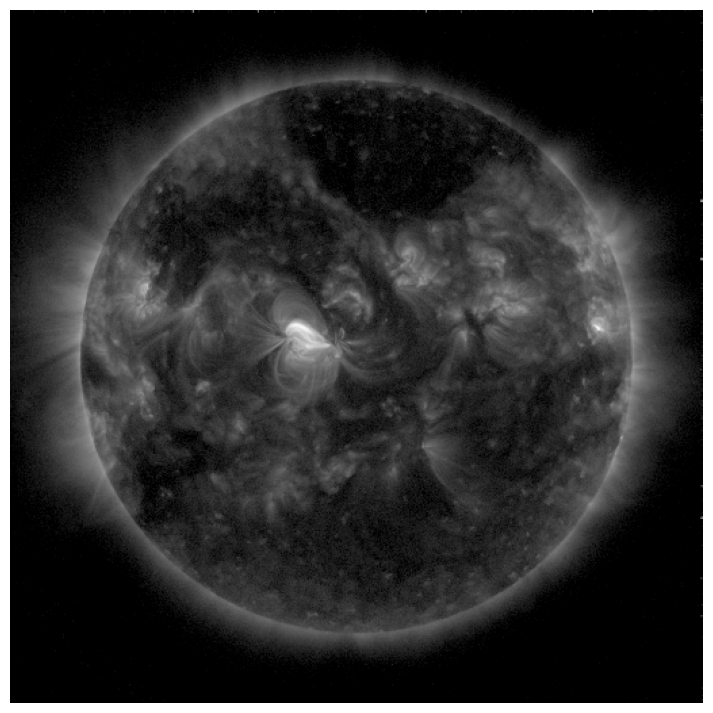

In [12]:
img = Image.open('./downloads/AIA20150104_0124_0094.png').convert('L')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

#### 5. Feed the network and get the reconstruction + required bit-rate

In [13]:
with torch.no_grad():
    out_net = net.forward(x)
out_net['x_hat'].clamp_(0, 1)
print(out_net.keys())

dict_keys(['x_hat', 'likelihoods'])


In [14]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

#### 6. Report PSNR and Bit-rate 

In [15]:
print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.2f}dB')
print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

PSNR: 35.86dB
Bit-rate: 0.570 bpp


#### 7. Visualize the reconstruction

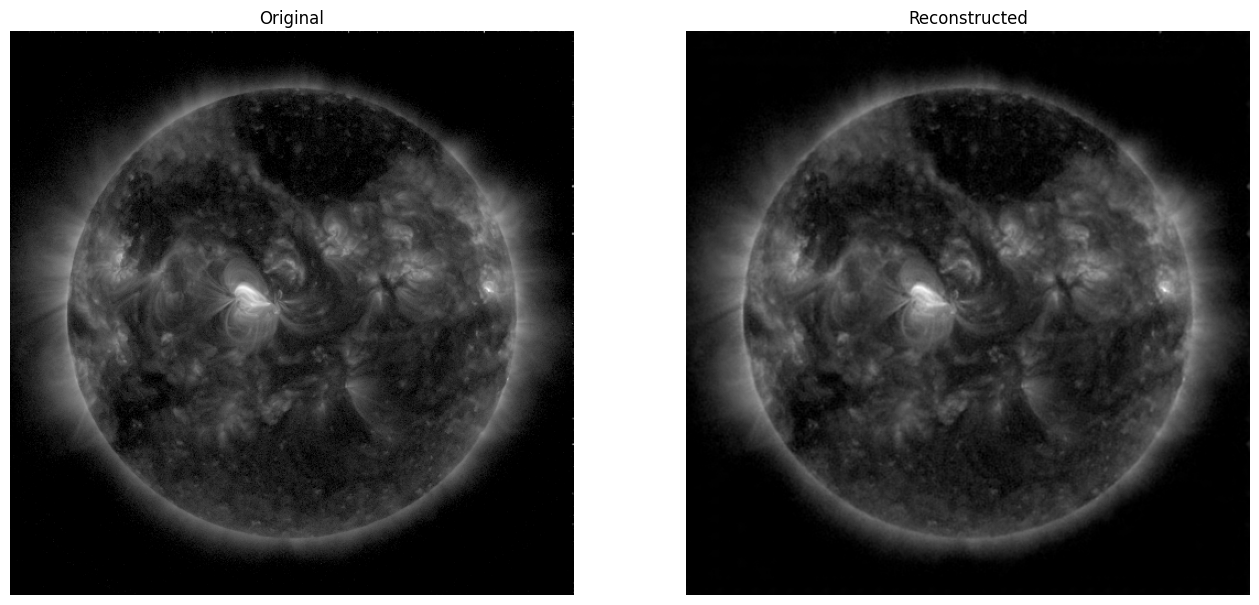

In [16]:
rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())

%matplotlib inline
fix, axes = plt.subplots(1, 2, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img, cmap='gray')
axes[0].title.set_text('Original')

axes[1].imshow(rec_net, cmap='gray')
axes[1].title.set_text('Reconstructed')


plt.show()